<a href="https://colab.research.google.com/github/mfmceneaney/DIRC_COLAB/blob/master/DIRC_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Using GPU speeds up CNN training
# Go to Edit > Notebook Settings > Hardware Accelerator and select GPU

In [2]:
print(" > Installing uproot...")
!pip install uproot

 > Installing uproot...
     |████████████████████████████████| 112kB 6.4MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 


In [3]:
import uproot

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import math

from __future__ import absolute_import, division, print_function, unicode_literals


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, metrics

# Added installation to fix the following warning message when fitting CNN
# You will have to run this cell twice and restart the runtime
# WARNING:tensorflow:Entity <function Function._initialize_uninitialized_variables..initialize_variables at 0x7fd89803cef0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, export AUTOGRAPH_VERBOSITY=10) and attach the full output. Cause: module 'gast' has no attribute 'Num'

!pip install gast==0.2.2

TensorFlow 2.x selected.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# initialize images
image_kplus = np.zeros(shape=(48,144))
image_piplus = np.zeros(shape=(48,144))
images_kplus = []
images_piplus = []
images_flat_kplus = []
images_flat_piplus = []

#h2_kplus = ROOT.TH2F("kplus","Hit Pattern K+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)
#h2_piplus = ROOT.TH2F("piplus","Hit Pattern pi+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)

# get data from files
print("Opening files")
piplus = uproot.open("/content/gdrive/My Drive/piplus_p3_theta4_flat.root")["dircml_flat"]
kplus = uproot.open("/content/gdrive/My Drive/kplus_p3_theta4_flat.root")["dircml_flat"]

# fill histogram with # photon hits
#plt.axis([0, 250, 0, 5000])
#plt.hist(NPixelsArr, 4000) #, 0, 100) #bins='auto')
#plt.title("Histogram with 'auto' bins")
#plt.show()

eventMax = 10000
eventCounter = 0

print("Filling image arrays")
# loop over kplus events
for (PixelTimes,PixelRows,PixelCols) in zip(kplus.array("PixelTime"),kplus.array("PixelRow"),kplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_kplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_kplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_kplus.append(image_single)
    images_flat_kplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

eventCounter = 0
        
# loop over piplus events
for (PixelTimes,PixelRows,PixelCols) in zip(piplus.array("PixelTime"),piplus.array("PixelRow"),piplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_piplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_piplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_piplus.append(image_single)
    images_flat_piplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

Opening files
Filling image arrays


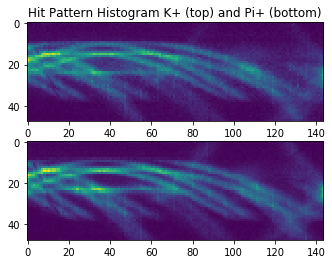

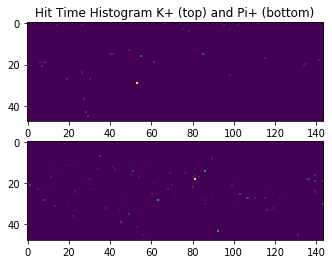

In [6]:
# draw cumulative image
plt.axis([-0.5, 143.5, -0.5, 47.5])
plt.subplot(2, 1, 1)
plt.title("Hit Pattern Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(image_kplus, cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(image_piplus, cmap='viridis')
plt.show()

# draw single event image
plt.subplot(2, 1, 1)
plt.title("Hit Time Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(images_kplus[0], cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(images_piplus[0], cmap='viridis')
#plt.show()

# draw ROOT image
#can = ROOT.TCanvas("cc","cc",600,500)
#can.Divide(1,2)
#can.cd(1)
#h2_kplus.Draw("colz")
#can.cd(2)
#h2_piplus.Draw("colz")
#can.Print("HitPattern.png")

In [7]:
# Split samples into training and testing
print("Splitting sample into training and testing subsets")
split = 2
n_kplus = len(images_kplus)
n_piplus = len(images_piplus)
n_total = n_kplus + n_piplus

images_train_kplus = images_kplus[:n_kplus // split]
images_train_piplus = images_piplus[:n_piplus // split]
n_train_kplus = len(images_train_kplus)
n_train_piplus = len(images_train_piplus)
n_train_total = n_train_kplus + n_train_piplus

images_test_kplus = images_kplus[n_kplus // split:]
images_test_piplus = images_piplus[n_piplus // split:]
n_test_kplus = len(images_test_kplus)
n_test_piplus = len(images_test_piplus)
n_test_total = n_test_kplus + n_test_piplus

data_train = np.concatenate((images_train_kplus, images_train_piplus))
data_test = np.concatenate((images_test_kplus, images_test_piplus))
data = np.concatenate((images_kplus, images_piplus))

target_train = np.concatenate((np.ones(n_train_kplus), np.zeros(n_train_piplus)))
target_test = np.concatenate((np.ones(n_test_kplus), np.zeros(n_test_piplus)))
target = np.concatenate((np.ones(n_kplus), np.zeros(n_piplus)))


print(data_train.shape)
print(data.shape)
print(target.shape)
print(np.unique(target))

print("Training size = %d" % len(data_train))
print("Testing size = %d" % len(data_test))
"""
print(images_kplus[1].shape)
print(images_piplus[0].shape)

print(data.max())
print(data_train.max())
print(data_test.max())
print(data.min())
print(data_train.min())
print(data_test.min())
"""

Splitting sample into training and testing subsets
(10000, 48, 144)
(20002, 48, 144)
(20002,)
[0. 1.]
Training size = 10000
Testing size = 10002


'\nprint(images_kplus[1].shape)\nprint(images_piplus[0].shape)\n\nprint(data.max())\nprint(data_train.max())\nprint(data_test.max())\nprint(data.min())\nprint(data_train.min())\nprint(data_test.min())\n'

In [8]:
# Reshape Data (?) 
data_train_images = data_train.reshape(len(data_train), 48, 144, 1)
target_train_images = target_train.reshape(len(target_train))

data_test_images = data_test.reshape(len(data_test), 48, 144, 1)
target_test_images = target_test.reshape(len(target_test))

# Normalize pixel absolute values to be between 0 and 1
data_train_images = data_train_images / data.max()
data_test_images = data_test_images / data.max()

#print(data_train_images.max())
#print(data_test_images.max())

print("Data shape: "+str(data_train_images.shape))
print("Target shape: "+str(target_train_images.shape))

Data shape: (10000, 48, 144, 1)
Target shape: (10000,)


In [0]:
import math
"""
#################################### Input Layers (changing all layers) ########################################
metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
minimum = 11
maximum = 101
step = 1
for n in range(minimum,maximum,step):
  print("Creating model "+str((n - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(n, (3, 3), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(2*n, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(2*n, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(2*n, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
  model.fit(data_train_images, target_train_images, epochs=5, verbose=0, batchsize=320)

  # Accuracy and Loss for CNN
  test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
  metrics[0].append(n)
  metrics[1].append(test_acc)
  metrics[2].append(test_loss)
  
  ###################  Evaluation  #################

  # Evaluate performance by comparing test and training classifier (model) response
  decisions = []
  for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
  
  ################  Find Purity and Chi2  ################  
  
  # set histogram parameters
  bins = 100
  low = min(np.min(d) for d in decisions)
  high = max(np.max(d) for d in decisions)
  low_high = (low,high)

  # make test and train decisions histograms for kaon
  hist_kaon_test, bins = np.histogram( decisions[0], bins=bins, range=low_high, density=False)
  hist_kaon_train, bins = np.histogram( decisions[2], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for kaon
  hist_kaon_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_kaon_test, hist_kaon_train)),np.add(hist_kaon_test,hist_kaon_train)))
  scale = len(decisions[2]) / sum(hist_kaon_chi2)
  err_kaon = np.sqrt(hist_kaon_chi2 * scale) / scale
  
  # make test and train decisions histograms for pion
  hist_pion_test, bins = np.histogram( decisions[1], bins=bins, range=low_high, density=False)
  hist_pion_train, bins = np.histogram( decisions[3], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for pion
  hist_pion_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_pion_test, hist_pion_train)),np.add(hist_pion_test,hist_pion_train)))
  scale = len(decisions[2]) / sum(hist_pion_chi2)
  err_pion = np.sqrt(hist_pion_chi2 * scale) / scale
  
  # find chi2 for kaon and pion and total
  chi2_kaon = sum(hist_kaon_chi2)
  chi2_pion = sum(hist_pion_chi2)
  chi2_total = chi2_kaon + chi2_pion
  err_total = math.sqrt(sum(err_kaon**2 + err_pion**2))
  metrics[3][0].append(chi2_kaon)
  metrics[3][1].append(chi2_pion)
  metrics[3][2].append(chi2_total)
  metrics[4][0].append(err_kaon)
  metrics[4][1].append(err_pion)
  metrics[4][2].append(err_total)


################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allLayers_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allLayers_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allLayers_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allLayers_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allLayers_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allLayers_acc.png")
files.download("allLayers_loss.png")
files.download("allLayers_chi2_kaon.png")
files.download("allLayers_chi2_pion.png")
files.download("allLayers_chi2_tot.png")

files.download("allLayers_acc.root")
files.download("allLayers_loss.root")
files.download("allLayers_chi2_kaon.root")
files.download("allLayers_chi2_pion.root")
files.download("allLayers_chi2_tot.root")


################################################################################################



#################################### Input Layers (Just changing first layer) ########################################
metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
minimum = 11
maximum = 101
step = 1
for n in range(minimum,maximum,step):
  print("Creating model "+str((n - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(n, (3, 3), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
  model.fit(data_train_images, target_train_images, epochs=5, verbose=0)

  # Accuracy and Loss for CNN
  test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
  metrics[0].append(n)
  metrics[1].append(test_acc)
  metrics[2].append(test_loss)
  
  ###################  Evaluation  #################

  # Evaluate performance by comparing test and training classifier (model) response
  decisions = []
  for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
  
  ################  Find Purity and Chi2  ################  
  
  # set histogram parameters
  bins = 100
  low = min(np.min(d) for d in decisions)
  high = max(np.max(d) for d in decisions)
  low_high = (low,high)

  # make test and train decisions histograms for kaon
  hist_kaon_test, bins = np.histogram( decisions[0], bins=bins, range=low_high, density=False)
  hist_kaon_train, bins = np.histogram( decisions[2], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for kaon
  hist_kaon_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_kaon_test, hist_kaon_train)),np.add(hist_kaon_test,hist_kaon_train)))
  scale = len(decisions[2]) / sum(hist_kaon_chi2)
  err_kaon = np.sqrt(hist_kaon_chi2 * scale) / scale
  
  # make test and train decisions histograms for pion
  hist_pion_test, bins = np.histogram( decisions[1], bins=bins, range=low_high, density=False)
  hist_pion_train, bins = np.histogram( decisions[3], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for pion
  hist_pion_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_pion_test, hist_pion_train)),np.add(hist_pion_test,hist_pion_train)))
  scale = len(decisions[2]) / sum(hist_pion_chi2)
  err_pion = np.sqrt(hist_pion_chi2 * scale) / scale
  
  # find chi2 for kaon and pion and total
  chi2_kaon = sum(hist_kaon_chi2)
  chi2_pion = sum(hist_pion_chi2)
  chi2_total = chi2_kaon + chi2_pion
  err_total = math.sqrt(sum(err_kaon**2 + err_pion**2))
  metrics[3][0].append(chi2_kaon)
  metrics[3][1].append(chi2_pion)
  metrics[3][2].append(chi2_total)
  metrics[4][0].append(err_kaon)
  metrics[4][1].append(err_pion)
  metrics[4][2].append(err_total)


################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputLayer_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputLayer_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputLayer_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputLayer_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputLayer_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputLayer_acc.png")
files.download("inputLayer_loss.png")
files.download("inputLayer_chi2_kaon.png")
files.download("inputLayer_chi2_pion.png")
files.download("inputLayer_chi2_tot.png")

files.download("inputLayer_acc.root")
files.download("inputLayer_loss.root")
files.download("inputLayer_chi2_kaon.root")
files.download("inputLayer_chi2_pion.root")
files.download("inputLayer_chi2_tot.root")


################################################################################################


###################################### Filter Size (changing all layers) #############################################
# ONLY WORKS FOR filterSize UP TO 8
metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
minimum = 1
maximum = 9
step = 1
for filterSize in range(minimum,maximum,step):
  print("Creating model "+str((filterSize - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(32, (filterSize, filterSize), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (filterSize, filterSize), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (filterSize, filterSize), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
  model.fit(data_train_images, target_train_images, epochs=5, verbose=0)

  # Accuracy and Loss for CNN
  test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
  metrics[0].append(filterSize)
  metrics[1].append(test_acc)
  metrics[2].append(test_loss)
  
  ###################  Evaluation  #################

  # Evaluate performance by comparing test and training classifier (model) response
  decisions = []
  for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
  
  ################  Find Purity and Chi2  ################  
  
  # set histogram parameters
  bins = 100
  low = min(np.min(d) for d in decisions)
  high = max(np.max(d) for d in decisions)
  low_high = (low,high)

  # make test and train decisions histograms for kaon
  hist_kaon_test, bins = np.histogram( decisions[0], bins=bins, range=low_high, density=False)
  hist_kaon_train, bins = np.histogram( decisions[2], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for kaon
  hist_kaon_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_kaon_test, hist_kaon_train)),np.add(hist_kaon_test,hist_kaon_train)))
  scale = len(decisions[2]) / sum(hist_kaon_chi2)
  err_kaon = np.sqrt(hist_kaon_chi2 * scale) / scale
  
  # make test and train decisions histograms for pion
  hist_pion_test, bins = np.histogram( decisions[1], bins=bins, range=low_high, density=False)
  hist_pion_train, bins = np.histogram( decisions[3], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for pion
  hist_pion_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_pion_test, hist_pion_train)),np.add(hist_pion_test,hist_pion_train)))
  scale = len(decisions[2]) / sum(hist_pion_chi2)
  err_pion = np.sqrt(hist_pion_chi2 * scale) / scale
  
  # find chi2 for kaon and pion and total
  chi2_kaon = sum(hist_kaon_chi2)
  chi2_pion = sum(hist_pion_chi2)
  chi2_total = chi2_kaon + chi2_pion
  err_total = math.sqrt(sum(err_kaon**2 + err_pion**2))
  metrics[3][0].append(chi2_kaon)
  metrics[3][1].append(chi2_pion)
  metrics[3][2].append(chi2_total)
  metrics[4][0].append(err_kaon)
  metrics[4][1].append(err_pion)
  metrics[4][2].append(err_total)


################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allFilters_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allFilters_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allFilters_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allFilters_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allFilters_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allFilters_acc.png")
files.download("allFilters_loss.png")
files.download("allFilters_chi2_kaon.png")
files.download("allFilters_chi2_pion.png")
files.download("allFilters_chi2_tot.png")

files.download("allFilters_acc.root")
files.download("allFilters_loss.root")
files.download("allFilters_chi2_kaon.root")
files.download("allFilters_chi2_pion.root")
files.download("allFilters_chi2_tot.root")


################################################################################################



###################################### Filter Size (Just changing first layer) #############################################
metrics = [ [], [], [],  [ [], [], [] ],  [ [], [], [] ]  ]
minimum = 1
maximum = 11
step = 1
for filterSize in range(minimum,maximum,step):
  print("Creating model "+str((filterSize - minimum + 1))+"...")
  
  # CNN takes 3 dimensional tensor input (image height, image width, color channel) 
  model = models.Sequential()
  # Padding='same' significantly improves results
  model.add(layers.Conv2D(32, (filterSize, filterSize), strides=(1,1), padding='same', activation='relu', input_shape=(48, 144, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # Final layer must have two outputs since we are distinguishing between only two particles
  model.add(layers.Dense(2, activation='softmax'))

  # Print CNN Architecture
  #model.summary()

  # Train CNN
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
  model.fit(data_train_images, target_train_images, epochs=5, verbose=0)

  # Accuracy and Loss for CNN
  test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
  metrics[0].append(filterSize)
  metrics[1].append(test_acc)
  metrics[2].append(test_loss)
  
  ###################  Evaluation  #################

  # Evaluate performance by comparing test and training classifier (model) response
  decisions = []
  for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
  
  ################  Find Purity and Chi2  ################  
  
  # set histogram parameters
  bins = 100
  low = min(np.min(d) for d in decisions)
  high = max(np.max(d) for d in decisions)
  low_high = (low,high)

  # make test and train decisions histograms for kaon
  hist_kaon_test, bins = np.histogram( decisions[0], bins=bins, range=low_high, density=False)
  hist_kaon_train, bins = np.histogram( decisions[2], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for kaon
  hist_kaon_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_kaon_test, hist_kaon_train)),np.add(hist_kaon_test,hist_kaon_train)))
  scale = len(decisions[2]) / sum(hist_kaon_chi2)
  err_kaon = np.sqrt(hist_kaon_chi2 * scale) / scale
  
  # make test and train decisions histograms for pion
  hist_pion_test, bins = np.histogram( decisions[1], bins=bins, range=low_high, density=False)
  hist_pion_train, bins = np.histogram( decisions[3], bins=bins, range=low_high, density=False)
  
  # find chi2 values and error for pion
  hist_pion_chi2 = np.nan_to_num(np.divide(np.square(np.subtract(hist_pion_test, hist_pion_train)),np.add(hist_pion_test,hist_pion_train)))
  scale = len(decisions[2]) / sum(hist_pion_chi2)
  err_pion = np.sqrt(hist_pion_chi2 * scale) / scale
  
  # find chi2 for kaon and pion and total
  chi2_kaon = sum(hist_kaon_chi2)
  chi2_pion = sum(hist_pion_chi2)
  chi2_total = chi2_kaon + chi2_pion
  err_total = math.sqrt(sum(err_kaon**2 + err_pion**2))
  metrics[3][0].append(chi2_kaon)
  metrics[3][1].append(chi2_pion)
  metrics[3][2].append(chi2_total)
  metrics[4][0].append(err_kaon)
  metrics[4][1].append(err_pion)
  metrics[4][2].append(err_total)
  
  

################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputFilter_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputFilter_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputFilter_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputFilter_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputFilter_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputFilter_acc.png")
files.download("inputFilter_loss.png")
files.download("inputFilter_chi2_kaon.png")
files.download("inputFilter_chi2_pion.png")
files.download("inputFilter_chi2_tot.png")

files.download("inputFilter_acc.root")
files.download("inputFilter_loss.root")
files.download("inputFilter_chi2_kaon.root")
files.download("inputFilter_chi2_pion.root")
files.download("inputFilter_chi2_tot.root")


################################################################################################
"""

###################################### Filter Sizes 2D ####################################

counter = 0
minFS = 1
maxFS1 = 11
maxFS2 = 11
stepFS = 1
stride = 1
metrics_acc   = np.zeros(shape=(2,maxFS1,maxFS2))
metrics_loss  = np.zeros(shape=(2,maxFS1,maxFS2))
metrics_chi2t = np.zeros(shape=(2,maxFS1,maxFS2))
metrics_chi2k = np.zeros(shape=(2,maxFS1,maxFS2))
metrics_chi2p = np.zeros(shape=(2,maxFS1,maxFS2))

# Loop through hyperparameter values
for filterSize1 in range(minFS,maxFS1,stepFS):
  for filterSize2 in range(minFS,maxFS2,stepFS):
    counter += 1
    print("Creating model "+str(counter)+"...")
    # CNN takes 3 dimensional tensor input (image height, image width, color channel)
    model = models.Sequential()
    # Padding significantly improves results
    model.add(layers.Conv2D(32, (filterSize1, filterSize2), strides=(stride,stride), padding='same', activation='relu', input_shape=(48, 144, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), strides=(stride,stride), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), strides=(stride,stride), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    # Final layer must have two outputs since we are distinguishing between only two particles
    model.add(layers.Dense(2, activation='softmax'))
  
    # Print CNN Architecture
    #model.summary()

    # Train CNN
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], verbose=0)
  
    model.fit(data_train_images, target_train_images, epochs=5, verbose=0)

    # Print Loss and Accuracy for CNN
    test_loss, test_acc = model.evaluate(data_test_images, target_test_images, verbose=0)
    #print("loss = "+str(test_loss))
    #print("accuracy = "+str(test_acc))
    metrics_acc[0][filterSize2-1][filterSize1-1] = test_acc  # Fairly certain first index should be row (y) of image and then second should be column (x)
    metrics_loss[1][filterSize2-1][filterSize1-1] = test_loss
  
  
####################### Plotting #######################

# draw single event image
f = plt.figure()
plt.title("Accuracy")
plt.imshow(metrics_acc[0],origin='lower',extent=(minFS-0.5,maxFS1+0.5,minFS-0.5,maxFS2-0.5)) #,extent=(minFS-0.5,maxFS1+0.5,minFS-0.5,maxFS2+0.5)
plt.colorbar()
plt.xlabel("Input filter width")
plt.ylabel("Input filter height")
plt.show()
f.savefig("filterSizes2D_acc.png")

f = plt.figure()
plt.title("Loss")
plt.imshow(metrics_loss[1],origin='lower',extent=(minFS-0.5,maxFS1+0.5,minFS-0.5,maxFS2-0.5)) #,extent=(minFS-0.5,maxFS1+0.5,minFS-0.5,maxFS2+0.5)
plt.colorbar()
plt.xlabel("Input filter width")
plt.ylabel("Input filter height")
plt.show()
f.savefig("filterSizes2D_loss.png")

from google.colab import files
files.download("filterSizes2D_acc.png")
files.download("filterSizes2D_loss.png")

################################################################################################


Creating model 1...
Creating model 2...
Creating model 3...
Creating model 4...
Creating model 5...
Creating model 6...
Creating model 7...
Creating model 8...
Creating model 9...
Creating model 10...
Creating model 11...
Creating model 12...
Creating model 13...
Creating model 14...
Creating model 15...
Creating model 16...
Creating model 17...
Creating model 18...
Creating model 19...
Creating model 20...
Creating model 21...
Creating model 22...
Creating model 23...
Creating model 24...
Creating model 25...
Creating model 26...
Creating model 27...
Creating model 28...
Creating model 29...
Creating model 30...
Creating model 31...
Creating model 32...
Creating model 33...
Creating model 34...
Creating model 35...
Creating model 36...
Creating model 37...
Creating model 38...
Creating model 39...
Creating model 40...
Creating model 41...
Creating model 42...
Creating model 43...
Creating model 44...
Creating model 45...
Creating model 46...
Creating model 47...
Creating model 48...
C

Plotting purity and χ²


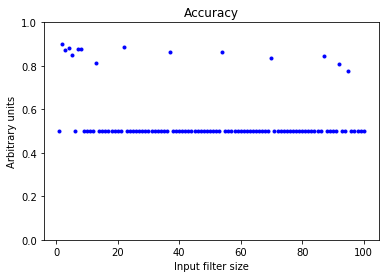

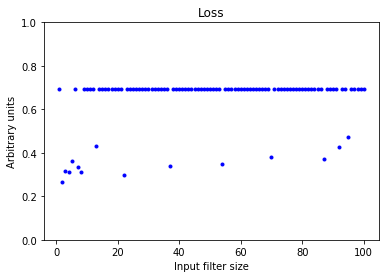

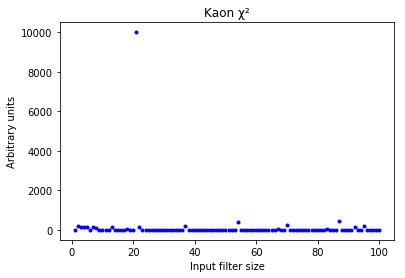

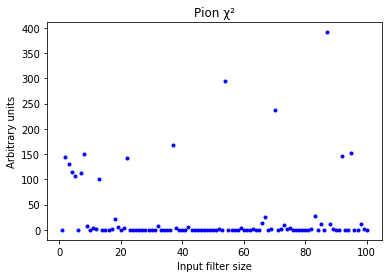

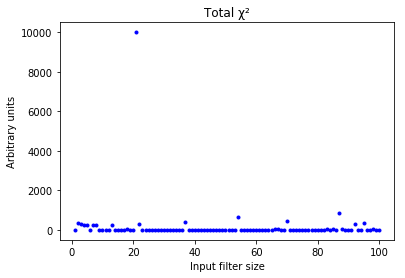

Converting plots to ROOT...


'################  Plot Purity and Chi2  ################\nprint("Plotting purity and χ²")\n\n# Plot accuracy\nf = plt.figure()\nplt.plot(metrics[0],metrics[1],\'b.\', scaley = False)\nplt.title("Accuracy")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_acc.png")\n\n# Plot loss\nf = plt.figure()\nplt.plot(metrics[0],metrics[2],\'b.\', scaley = False)\nplt.title("Loss")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_loss.png")\n\n# Plot kaon chi2\nf = plt.figure()\nplt.plot(metrics[0],metrics[3][0],\'b.\')\nplt.title("Kaon χ²")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_chi2_kaon.png")\n\n# Plot pion chi2\nf = plt.figure()\nplt.plot(metrics[0],metrics[3][1],\'b.\')\nplt.title("Pion χ²")\nplt.xlabel("Filter size")\nplt.ylabel("Arbitrary units")\nplt.show()\nf.savefig("allFilters_chi2_pion.png")\n\n# Plot total chi2\nf = plt.figure()\nplt.plot(metri

In [0]:
################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputFilter_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputFilter_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputFilter_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputFilter_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputFilter_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputFilter_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputFilter_acc.png")
files.download("inputFilter_loss.png")
files.download("inputFilter_chi2_kaon.png")
files.download("inputFilter_chi2_pion.png")
files.download("inputFilter_chi2_tot.png")

files.download("inputFilter_acc.root")
files.download("inputFilter_loss.root")
files.download("inputFilter_chi2_kaon.root")
files.download("inputFilter_chi2_pion.root")
files.download("inputFilter_chi2_tot.root")


"""################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Filter size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allFilters_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allFilters_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allFilters_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allFilters_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allFilters_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allFilters_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allFilters_acc.png")
files.download("allFilters_loss.png")
files.download("allFilters_chi2_kaon.png")
files.download("allFilters_chi2_pion.png")
files.download("allFilters_chi2_tot.png")

files.download("allFilters_acc.root")
files.download("allFilters_loss.root")
files.download("allFilters_chi2_kaon.root")
files.download("allFilters_chi2_pion.root")
files.download("allFilters_chi2_tot.root")


################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("inputLayer_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("inputLayer_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("inputLayer_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("inputLayer_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("inputLayer_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("inputLayer_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("inputLayer_acc.png")
files.download("inputLayer_loss.png")
files.download("inputLayer_chi2_kaon.png")
files.download("inputLayer_chi2_pion.png")
files.download("inputLayer_chi2_tot.png")

files.download("inputLayer_acc.root")
files.download("inputLayer_loss.root")
files.download("inputLayer_chi2_kaon.root")
files.download("inputLayer_chi2_pion.root")
files.download("inputLayer_chi2_tot.root")


################################################################################################




################  Plot Purity and Chi2  ################
print("Plotting purity and \u03C7\u00b2")

# Plot accuracy
f = plt.figure()
plt.plot(metrics[0],metrics[1],'b.', scaley = False)
plt.title("Accuracy")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_acc.png")

# Plot loss
f = plt.figure()
plt.plot(metrics[0],metrics[2],'b.', scaley = False)
plt.title("Loss")
plt.xlabel("Input layer size")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_loss.png")

# Plot kaon chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][0],'b.')
plt.title("Kaon \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_kaon.png")

# Plot pion chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][1],'b.')
plt.title("Pion \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_pion.png")

# Plot total chi2
f = plt.figure()
plt.plot(metrics[0],metrics[3][2],'b.')
plt.title("Total \u03C7\u00b2")
plt.xlabel("Layer sizes")
plt.ylabel("Arbitrary units")
plt.show()
f.savefig("allLayers_chi2_tot.png")
  
# Convert accuracy and loss plots into ROOT histograms
print("Converting plots to ROOT...")

file = uproot.recreate("allLayers_acc.root", compression=uproot.ZLIB(4))
file["acc"] = np.histogram2d(metrics[0],metrics[1])

file = uproot.recreate("allLayers_loss.root", compression=uproot.ZLIB(4))
file["loss"] = np.histogram2d(metrics[0],metrics[2])

file = uproot.recreate("allLayers_chi2_kaon.root", compression=uproot.ZLIB(4))
file["chi2k"] = np.histogram2d(metrics[0],metrics[3][0])

file = uproot.recreate("allLayers_chi2_pion.root", compression=uproot.ZLIB(4))
file["chi2p"] = np.histogram2d(metrics[0],metrics[3][1])

file = uproot.recreate("allLayers_chi2_tot.root", compression=uproot.ZLIB(4))
file["chi2t"] = np.histogram2d(metrics[0],metrics[3][2])

# Download png and root files
print("Downloading files...")

from google.colab import files
files.download("allLayers_acc.png")
files.download("allLayers_loss.png")
files.download("allLayers_chi2_kaon.png")
files.download("allLayers_chi2_pion.png")
files.download("allLayers_chi2_tot.png")

files.download("allLayers_acc.root")
files.download("allLayers_loss.root")
files.download("allLayers_chi2_kaon.root")
files.download("allLayers_chi2_pion.root")
files.download("allLayers_chi2_tot.root")
"""

In [0]:
import os
print( os.getcwd() )
#print( os.listdir() )

/content
['.config', 'inputLayer_acc.png', 'gdrive', 'inputLayer_loss.png', 'sample_data']


In [0]:
from google.colab import files
files.download("inputLayer_acc.png")


Filling histograms...


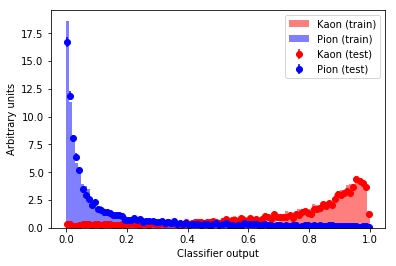

In [0]:
###################  Evaluation  #################

# Evaluate performance by comparing test and training classifier (model) response
decisions = []
for (X,y) in ((data_train_images, target_train_images), (data_test_images, target_test_images)):
    d1 = model.predict_proba(X[y>0.5])[:,1].ravel()
    d2 = model.predict_proba(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
    
print("Filling histograms...")

bins = 100
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)

plt.clf()
# Plot training decisions
plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Kaon (train)')
plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Pion (train)')

# make histogram and get error bars
hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, density=True)
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# plot histogram for signal test sample (Kaon Test)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Kaon (test)')

# make and plot histogram for background test sample (Pion Test)
hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Pion (test)')

plt.xlabel("Classifier output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.show()